In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

# This source code is licensed under the license found in the LICENSE file in the root directory of this source tree.

## Optimizing a high-dimensional function with ALEBO
This notebook provides a simple example of how to optimize a high-dimensional function with ALEBO.

ALEBO is described in:

B Letham, R Calandra, A Rai, E Bakshy (2020) Re-examining linear embeddings for high-dimensional Bayesian optimization. _Submitted_.

See the github repository for the full code used for the benchmark experiments in the paper.

We use Ax to manage the optimization loop; see https://ax.dev/tutorials/gpei_hartmann_loop.html for more documentation on the API used here.

In [1]:
# Define a function to be optimized.
# Here we use a simple synthetic function with a d=2 true linear embedding, in
# a D=100 ambient space.

import numpy as np
from ax.utils.measurement.synthetic_functions import branin


def branin_evaluation_function(parameterization):
    # Evaluates Branin on the first two parameters of the parameterization.
    # Other parameters are unused.
    x = np.array([parameterization["x0"], parameterization["x1"]])
    return {"objective": (branin(x), 0.0)}

In [2]:
# Define the parameters in the format expected by Ax.
# Here we define a D=100 search space by augmenting the real Branin parameters
# with 98 unused parameters.

parameters = [
    {"name": "x0", "type": "range", "bounds": [-5.0, 10.0], "value_type": "float"},
    {"name": "x1", "type": "range", "bounds": [0.0, 15.0], "value_type": "float"},
]
parameters.extend([
    {"name": f"x{i}", "type": "range", "bounds": [-5.0, 10.0], "value_type": "float"}
    for i in range(2, 100)
])

In [3]:
# Setup the ALEBO optimization strategy
# We must specify the ambient dimensionality (determined by the problem - here 100),
# the embedding dimensionality, and the number of initial random points. As
# discussed in the paper, the embedding dimensionality should be larger than the
# true subspace dimensionality. Here we use 4, since the true dimensionality is 2;
# see the paper for more discussion on this point.

from ax.modelbridge.strategies.alebo import ALEBOStrategy

alebo_strategy = ALEBOStrategy(D=100, d=4, init_size=5)

[INFO 01-09 12:20:47] ax.modelbridge.generation_strategy: Using model via callable function, so optimization is not resumable if interrupted.


In [4]:
# Run the optimization loop with that strategy
# This will take about 30 mins to run

from ax.service.managed_loop import optimize

best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    experiment_name="branin_100",
    objective_name="objective",
    evaluation_function=branin_evaluation_function,
    minimize=True,
    total_trials=30,
    generation_strategy=alebo_strategy,
)

[INFO 01-09 12:20:50] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 01-09 12:20:50] ax.service.managed_loop: Running optimization trial 1...
[INFO 01-09 12:20:52] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-09 12:20:54] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-09 12:20:55] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-09 12:20:57] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-09 12:20:59] ax.service.managed_loop: Running optimization trial 6...
[INFO 01-09 12:22:43] ax.service.managed_loop: Running optimization trial 7...
[INFO 01-09 12:24:06] ax.service.managed_loop: Running optimization trial 8...
[INFO 01-09 12:25:29] ax.service.managed_loop: Running optimization trial 9...
[INFO 01-09 12:26:49] ax.service.managed_loop: Running optimization trial 10...
[INFO 01-09 12:28:26] ax.service.managed_loop: Running optimization trial 11...
[INFO 01-09 12:29:41] ax.service.managed_

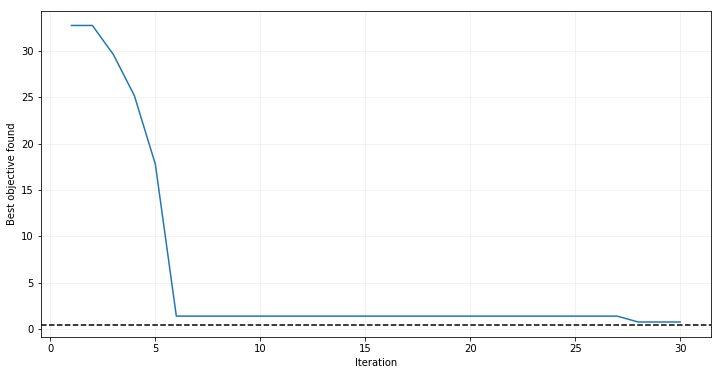

In [20]:
# Extract out the objective values at each iteration and make a plot

from matplotlib import pyplot as plt

objectives = np.array([trial.objective_mean for trial in experiment.trials.values()])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.grid(alpha=0.2)
ax.plot(range(1, 31), np.minimum.accumulate(objectives))
ax.axhline(y=branin.fmin, ls='--', c='k')
ax.set_xlabel('Iteration')
ax.set_ylabel('Best objective found');